In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread("sfinge.bmp") 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

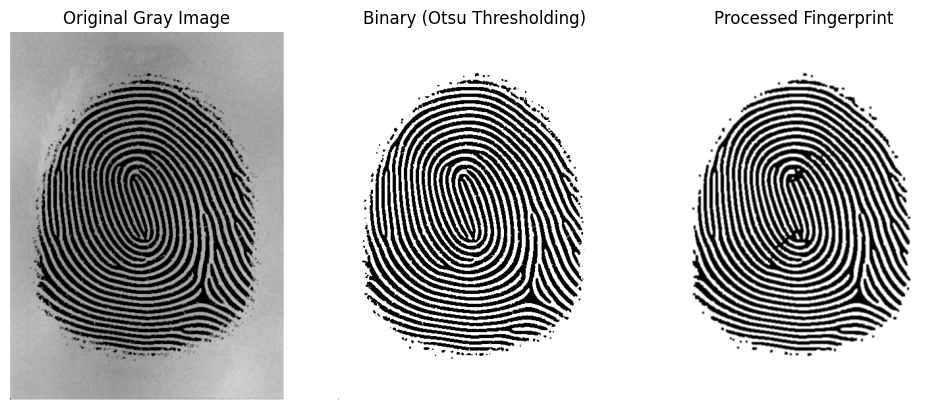

In [3]:
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Structural Element for Morphological Operations
kernel = np.ones((3, 3), np.uint8)

# Erosion (Reduces noise)
eroded = cv2.erode(binary, kernel, iterations=1)

# Expansion (Refines lines)
dilated = cv2.dilate(eroded, kernel, iterations=1)

# Clears isolated noises
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Fills in gaps
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

# Noise Reduction - Gaussian Blur
denoised = cv2.GaussianBlur(closed, (3, 3), 0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Gray Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binary (Otsu Thresholding)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised, cmap='gray')
plt.title("Processed Fingerprint")
plt.axis('off')

plt.show()

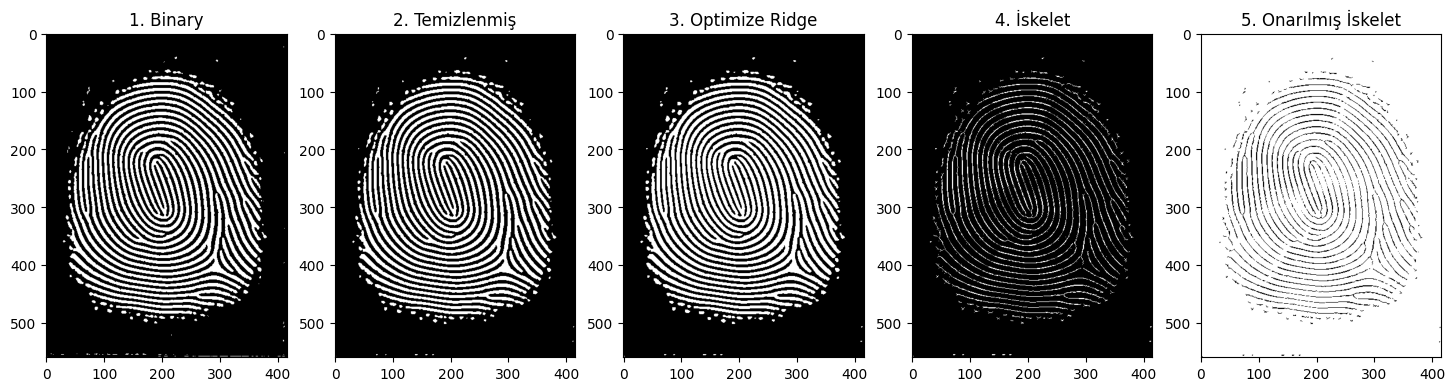

True

In [4]:

def robust_skeletonize(image):

    skeleton = np.zeros(image.shape, np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    threshold = 10  
    
    while True:
        eroded = cv2.erode(image, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(image, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        image = eroded.copy()
        
      
        if cv2.countNonZero(image) < threshold:
            break
            
    return skeleton


img = cv2.imread('sfinge.bmp', 0)
denoised = cv2.bilateralFilter(img, 9, 75, 75)


binary = cv2.adaptiveThreshold(denoised, 255, 
                             cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY_INV, 15, 4)


kernel_clean = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_clean, iterations=1)


kernel_thick = cv2.getStructuringElement(cv2.MORPH_RECT, (2,1))  # Yatay ridge'leri koru
thickened = cv2.dilate(cleaned, kernel_thick, iterations=1)


skeleton = robust_skeletonize(thickened)


final = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, 
                       cv2.getStructuringElement(cv2.MORPH_CROSS, (2,2)))


final = cv2.bitwise_not(final)


plt.figure(figsize=(18,6))
plt.subplot(151), plt.imshow(binary, cmap='gray'), plt.title('1. Binary')
plt.subplot(152), plt.imshow(cleaned, cmap='gray'), plt.title('2. Temizlenmiş')
plt.subplot(153), plt.imshow(thickened, cmap='gray'), plt.title('3. Optimize Ridge')
plt.subplot(154), plt.imshow(skeleton, cmap='gray'), plt.title('4. İskelet')
plt.subplot(155), plt.imshow(final, cmap='gray'), plt.title('5. Onarılmış İskelet')
plt.show()


cv2.imwrite('final_skeleton.png', final)

In [5]:
binary_matrix = (final == 0).astype(np.uint8)
print(binary_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


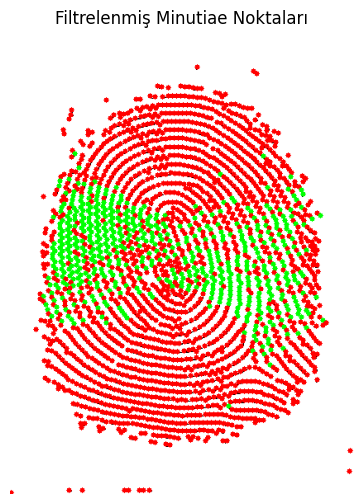

In [7]:

def find_minutiae(final):
    minutiae = []
    rows, cols = final.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if final[i, j] == 255:  # Sadece beyaz pikselleri kontrol et
                neighbors = [
                    final[i-1, j-1], final[i-1, j], final[i-1, j+1],
                    final[i, j-1],                     final[i, j+1],
                    final[i+1, j-1], final[i+1, j], final[i+1, j+1]
                ]
                # Crossing number hesapla
                cn = 0
                for k in range(8):
                    cn += abs(int(neighbors[k]) - int(neighbors[(k+1)%8])) / 255
                cn /= 2
                
                if cn == 1:  # Uç nokta
                    minutiae.append((j, i, 'end'))
                elif cn == 3:  # Çatallanma
                    minutiae.append((j, i, 'bif'))
    return minutiae

minutiae = find_minutiae(final)


def filter_minutiae(minutiae, min_distance=5):
    filtered = []
    for m in minutiae:
        x, y, typ = m
        keep = True
        for (fx, fy, _) in filtered:
            if np.sqrt((x - fx)**2 + (y - fy)**2) < min_distance:
                keep = False
                break
        if keep:
            filtered.append(m)
    return filtered

filtered_minutiae = filter_minutiae(minutiae)

# Sonuçları görselleştir
output = cv2.cvtColor(final, cv2.COLOR_GRAY2BGR)
for (x, y, typ) in filtered_minutiae:
    if typ == 'end':
        cv2.circle(output, (x, y), 3, (0, 0, 255), -1)  # Kırmızı: Uç nokta
    else:
        cv2.circle(output, (x, y), 3, (0, 255, 0), -1)  # Yeşil: Çatallanma

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Filtrelenmiş Minutiae Noktaları")
plt.axis('off')
plt.show()